In [6]:
# import modules
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, log_loss, f1_score

import random
from math import floor
from scipy.stats import mode, scoreatpercentile

print("Seaborn version : ", sns.__version__)
sns.set()
#sns.set_style('whitegrid')
sns.set_color_codes()
sns.set_theme(style="ticks", palette="pastel")

Seaborn version :  0.11.1


# 신용카드 사용자 연체 예측 AI 경진대회

- 주제: 신용카드 사용자 데이터를 보고 사용자의 대금 연체 정도를 예측하는 알고리즘 개발 
- 목적: 신용카드 사용자들의 개인 신상정보 데이터로 **사용자의 신용카드 대금 연체 정도를 예측**

- 데이터 설명:
    - **gender :** 고객의 성별, **binary**
    - **car :** 고객의 자차 보유 유무, **binary**
    - **reality :** 고객의 부동산 보유 유무, **binary**
    - **child_num :** 고객의 자녀 수, **integer**
    - **income_total :** 고객의 총 소득, **numeric**
    - **income_type :** 고객의 소득 유형, **category**
    - **edu_type :** 고객의 최종 학력, **category**
    - **family_type :** 고객의 본인의 혼인관련 상태, **category**
    - **house_type :** 고객의 거주지 형태, **category**
    - **DAYS_BIRTH :** (고객의 생일) - (현재 일), **integer**, **numeric**
    - **DAYS_EMPLOYED :** (고객의 첫 고용일) - (현재 일), **numeric**
    - **FLAG_MOBIL :** 고객의 본인 휴대폰 전화번호 등록 여부, **binary**
    - **work_phone :** 고객의 본인 직장 전화번호 등록 여부, **binary**
    - **phone :** 고객의 집 전화번호 등록 여부, **binary**
    - **email :** 고객의 이메일 등록여부, **binary**
    - **occyp_type :** 고객의 고용 형태, **category**
    - **family_size :** 고객의 가족의 크기, **integer**, **numeric**
    - **begin_month :** (고객이 카드를 발급한 월) - (현재 월), **integer**, **numeric**  
    
    - **<u>credit</u>** : 해당 신용카드의 대금 연체 정도 (0,1,2 : 커질수록 대금 연체 정도가 높다. target variable)
    
    
## 학습 목표에 대한 논의
### 학습 목표
- ```Credit``` 변수의 클래스 예측.
    - **classes :** 0, 1, 2
    - **description :** 사용자의 신용카드 대금 연체 정도.  
    - 각 값은 **상대적인 크기**에 대한 정보를 가지고 있다.
    - **imbalaced data**

- 다양한 features가 존재하지만 대부분의 feature에서 class의 비율은 일정하다.

- 데이터 관측치의 기준은 **'사용자'**가 아니라 **'카드'**이다. 
    - 카드 정보에만 해당하는 begin_month를 제외하고 모든 값이 일치하는 관측치는 같은 고객이라고 판단한다.
    - 가설) 카드 사용자를 몇 가지 유형으로 분류 할 수 있고, 유형에 따라 begin_month에 해당하는 credit 값들의 기준이 다르다.
    
- 평가기준:
    - **logloss** : 작을수록 좋은 결과


In [2]:
# upload data
train = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/train.csv',
                   index_col=0)
test = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/test.csv',
                  index_col=0)
submit = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/sample_submission.csv')

In [5]:
# shape of data
print(train.shape)
print(test.shape)

(26457, 19)
(10000, 18)
(10000, 4)


- 데이터는 총 26457개의 관측치와 총 18개의 feature 그리고 target variable로 이루어져있다.
- public score는 test data의 credit variable 을 예측하는 것으로 총 10000개의 데이터를 예측해야한다.

- table
    1. EDA
    2. Preprocessing
    3. modeling
    
---
## EDA
### target variable: credit

In [29]:
train.credit.value_counts()

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64

In [30]:
train.credit.value_counts(normalize = True)

2.0    0.641343
1.0    0.236875
0.0    0.121783
Name: credit, dtype: float64

- 전체 train data set 에서 target variable의 class ratio는 약 2:1:0 = **0.64 : 0.23 : 0.12**이다. 클래스 간 불균형이다.

### binary variables
- gender
- car
- reality
- FLAG_MOBIL
- work_phone
- phone
- email

In [54]:
train.FLAG_MOBIL.value_counts()

1    26457
Name: FLAG_MOBIL, dtype: int64

- FLAG_MOBIL의 원소는 결측치 없이 모두 1으로, 변수로써 가치가 없다. -> 제거

In [150]:
print('<binary variables distribution of the train data>\n')
bin_cols = ['gender', 'car', 'reality', 'work_phone', 'phone', 'email']
for cols in bin_cols : 
    print('* Column name : {}'.format(cols))
    print(train[cols].value_counts(),'\n')


<binary variables distribution of the train data>

* Column name : gender
F    17697
M     8760
Name: gender, dtype: int64 

* Column name : car
N    16410
Y    10047
Name: car, dtype: int64 

* Column name : reality
Y    17830
N     8627
Name: reality, dtype: int64 

* Column name : work_phone
0    20511
1     5946
Name: work_phone, dtype: int64 

* Column name : phone
0    18672
1     7785
Name: phone, dtype: int64 

* Column name : email
0    24042
1     2415
Name: email, dtype: int64 



<Figure size 360x720 with 0 Axes>

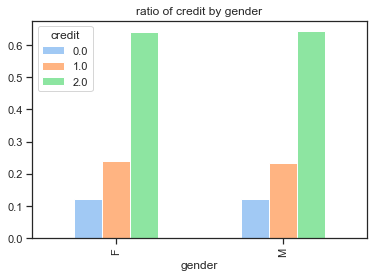

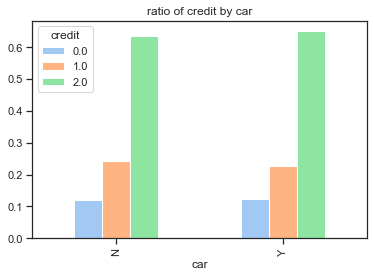

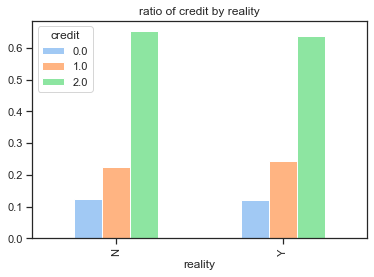

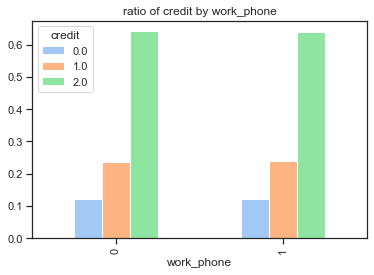

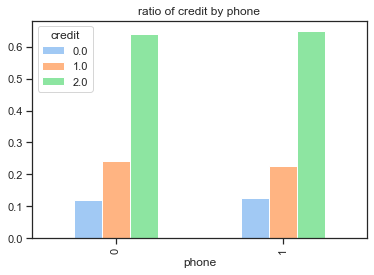

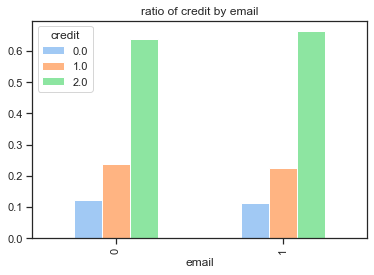

In [112]:
for cols in bin_cols :
    train.groupby(cols).credit.value_counts(normalize = True).unstack().plot(kind = 'bar', title = 'ratio of credit by {}'.format(cols))

- binary columns 에 속하는 'gender', 'car', 'reality', 'work_phone', 'phone', 'email'는 positive와 negative 사이에 credit class간의 비율 차이가 거의 보이지 않는다.

In [263]:
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['gender', 'car', 'reality', 'work_phone', 'phone', 'email']:
    train[bin_feature], uniques = pd.factorize(train[bin_feature])




### numeric variables
- child_num
- family_size
- income_total
- DAYS_BIRTH
- DAYS_EMPLOYED
- begin_month

#### child_num
- integer
- 슬하 자녀의 수

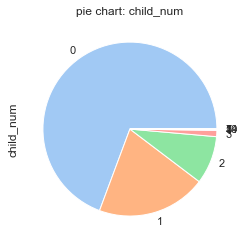

In [264]:
train.child_num.value_counts().sort_index().plot(kind = 'pie')
plt.title('pie chart: child_num')
plt.show()

In [265]:
train.child_num.value_counts().sort_index()

0     18340
1      5386
2      2362
3       306
4        47
5        10
7         2
14        3
19        1
Name: child_num, dtype: int64

- 대부분의 값이 0, 1, 2, 3에 속한다.
- 극히 일부 값들이 7, 14, 19와 같은 값을 지닌다. -> 이상치로 판단하여 train data에서 제거해주도록 한다.

#### family_size
- integer
- 본인 및 배우자, 자녀의 수를 합한 변수 또는 현 거주지에 같이 살고있는 가족의 수라고 추정.(본 관측치의 사람들은 모두 성인으로, 가족에 부모님의 수는 고려하지 않는 것으로 추정된다.)

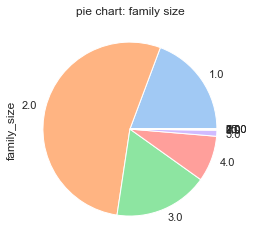

In [266]:
train.family_size.value_counts().sort_index().plot(kind = 'pie')
plt.title('pie chart: family size')
plt.show()

In [267]:
train.family_size.value_counts().sort_index()

1.0      5109
2.0     14106
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
9.0         2
15.0        3
20.0        1
Name: family_size, dtype: int64

- family_type 변수와의 관계를 통해 family_size가 결정된다. (나중에 family_type 변수 설명시에 논한다.)


#### income_total
- numeric, seems like positive-float
- 카드 사용자의 총 소득

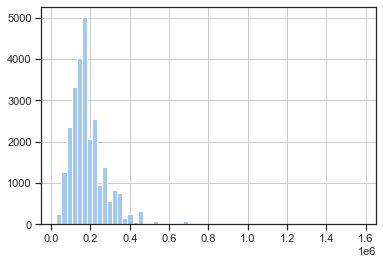

In [268]:
train.income_total.hist(bins = 60)
plt.show()

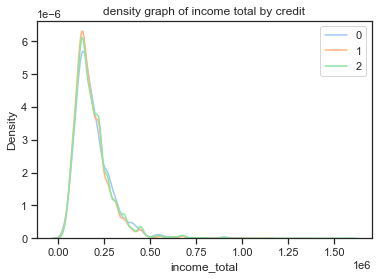

In [269]:
sns.kdeplot(x = 'income_total', data = train[train.credit == 0])
sns.kdeplot(x = 'income_total', data = train[train.credit == 1])
sns.kdeplot(x = 'income_total', data = train[train.credit == 2])
plt.legend([0,1,2])
plt.title('density graph of income total by credit')
plt.show()

- credit class 별 income_total의 density graph를 봤을때, income_total만으로 credit을 특정하기는 어렵다는 것을 알 수 있다.
- 다른 변수와의 조합 또는 변수 재생성으로 더 나은 예측력을 기대

#### DAYS_BIRTH
- 나이와 연관된 변수
- 시각적으로 확인하기 쉽게 나이에 대한 변수로 바꿔준다. => ```_age```

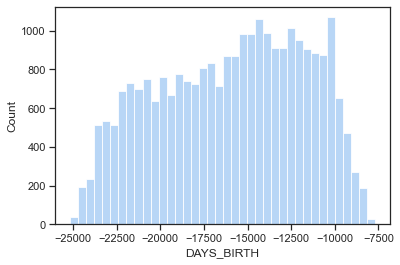

In [270]:
sns.histplot(train.DAYS_BIRTH)
plt.show()

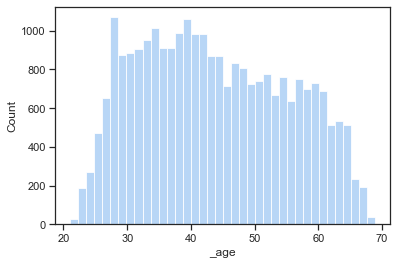

In [271]:
train['_age'] = train.DAYS_BIRTH.apply(lambda x : -x/365.25)
sns.histplot(train._age)
plt.show()

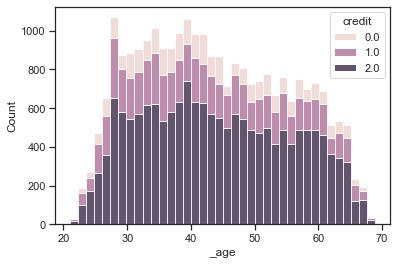

In [299]:
sns.histplot(x = '_age', data = train, hue = 'credit', multiple= 'stack')
plt.show()

In [273]:
print(max(train._age), min(train._age))

68.86242299794661 21.09514031485284


- 대체적으로 나이에 대해 고른 분포를 보인다. 
- 나이는 21살부터 68세까지이며, 모두 성인이다.

#### DAYS_EMPLOYED
- 해당 카드 이용 고객의 근무 기간과 관련된 변수
- 결측값으로 보이는 값들이 존재한다. 이 결측값들이 의미하는 바가 무엇인지 파악해야한다.

In [274]:
train.DAYS_EMPLOYED[train.DAYS_EMPLOYED > 0].value_counts()

365243    4438
Name: DAYS_EMPLOYED, dtype: int64

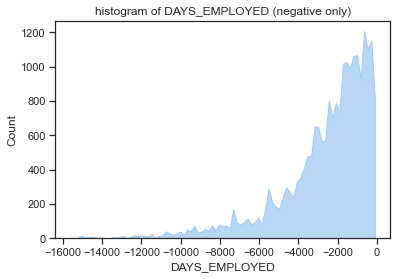

In [326]:
sns.histplot(train.DAYS_EMPLOYED[train.DAYS_EMPLOYED <= 0], element = "poly")
plt.title('histogram of DAYS_EMPLOYED (negative only)')
plt.show()

In [276]:
# 음수 중 최대 값은 -17로 나타난다.
train.DAYS_EMPLOYED[train.DAYS_EMPLOYED <= 0].max()

-17

In [284]:
# DAYS_EMPLOYED == 365243 인 데이터는 occyp_type 변수에서 결측치가 나타난다.
np.mean(train[train.DAYS_EMPLOYED == 365243].occyp_type.isna())

1.0

- 결측치로 보이는 모든 값이 occyp_type 또한 결측값으로 나타났다. => occyp_type 변수 설명에서 논함.

In [286]:
# 365243 값을 가지는 데이터를 0으로 치환, 양수로 변환
train['adj_DAYS_EMPLOYED_replace_0'] = -train.DAYS_EMPLOYED.replace({365243 : 0})
train['DAYS_EMPLOYED_missing'] = (train.DAYS_EMPLOYED == 365243).astype('int')

- 결측치로 보이는 값(365243)을 -1로 변경해주고
- 음수가 된 모든 값들을 양수로 변환시켜준 변수를 재생성 => ```adj_DAYS_EMPLOYED_replace_0```
- DAYS_EMPLOYED == 365243, 에 해당하는 변수를 구분해주는 변수 생성 => ```DAYS_EMPLOYED_missing```
- 재생성된 데이터에게 기대하는 점: 다른 변수와 조합 기회

#### begin_month
- integer
- 카드가 발급된 후 경과한 시간에 대한 데이터로 개월으로 구분되어있다.

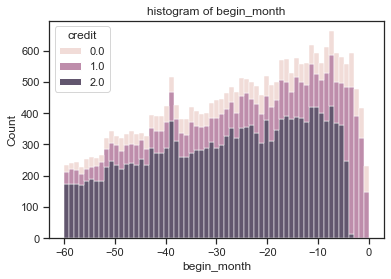

In [334]:
sns.histplot(x = 'begin_month', bins = 61, hue = 'credit', data = train, multiple = 'stack' )
plt.title('histogram of begin_month')
plt.show()

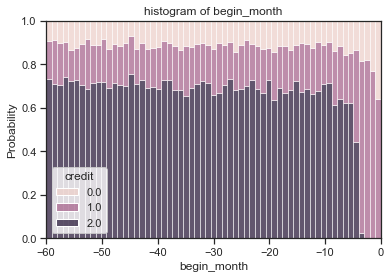

In [333]:
sns.histplot(x = 'begin_month', bins = 61, stat = 'probability',hue = 'credit', data = train, multiple = 'fill' )
plt.title('histogram of begin_month')
plt.show()

In [ ]:
train['adj_begin_month'] = -train.begin_month

- 양수로 전환시켜준 변수 추가 => ```adj_begin_month```
- 카드발급한지 3개월 이내에는 거의 credit == 2 가 없다.

### categorial variables
- income_type
- edu_type
- family_type
- house_type
- occyp_type

#### income_type
- 소득유형에 따른 분류

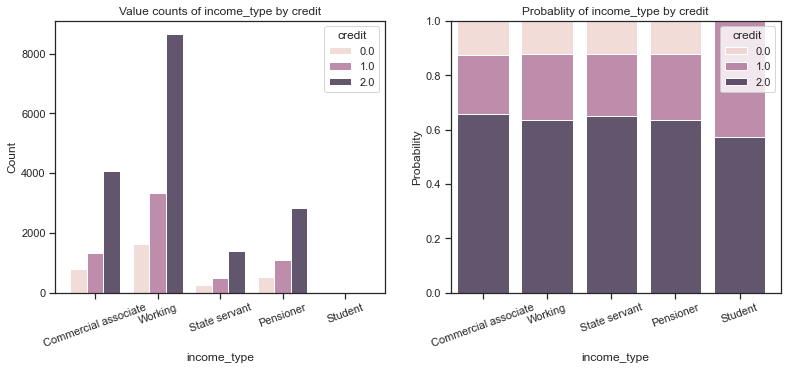

In [374]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.histplot(x = 'income_type', stat = 'count', data = train, hue = 'credit', 
             multiple= 'dodge', shrink=0.8)
plt.title('Value counts of income_type by credit')
plt.xticks(rotation = 20)

plt.subplot(1,2,2)
sns.histplot(x = 'income_type', stat = 'probability', data = train, hue = 'credit', 
             multiple= 'fill', shrink=0.8)
plt.title('Probablity of income_type by credit')
plt.xticks(rotation = 20)
plt.show()

In [354]:
train.income_type.value_counts()

Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64

In [361]:
train.loc[train.income_type == 'Student'][['income_total', 'income_type', 'occyp_type', '_age', 'credit']]

,income_total,income_type,occyp_type,_age,credit
index,,,,,
2990,171000.0,Student,Core staff,51.351129,2.0
3602,171000.0,Student,Core staff,51.351129,1.0
6223,135000.0,Student,NaN,24.955510,2.0
8936,171000.0,Student,Core staff,51.351129,1.0
11646,112500.0,Student,Laborers,33.201916,2.0
21681,171000.0,Student,Core staff,51.351129,1.0
23119,112500.0,Student,Laborers,33.201916,2.0


In [365]:
pd.crosstab(train.income_type, train.occyp_type)

occyp_type,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
income_type,,,,,,,,,,,,,,,,,,
Commercial associate,363,80,92,609,418,21,306,15,1075,33,846,127,96,43,860,14,138,40
Pensioner,1,0,0,2,1,0,0,0,3,0,1,1,0,0,0,0,0,0
State servant,69,16,41,655,87,3,148,6,142,3,226,274,15,0,10,22,14,31
Student,0,0,0,4,0,0,0,0,2,0,0,0,0,0,0,0,0,0
Working,469,307,324,1376,1069,38,586,20,3290,91,1094,462,132,20,1669,61,272,53


In [366]:
train['adj_income_type'] = train.income_type
train.loc[train.income_type == 'Student', 'adj_income_type'] = 'Working'

- student에 해당하는 관측치의 개수가 매우 적기때문에 'Working' 범주에 속하게 한다. => ```adj_income_type```

#### edu_type
- 카드 사용자의 최종학력에 대한 변수
- 총 5개의 범주로 구분되어있으며, 다음과 같이 더 크다는 순으로 학력이 높다고 한다.
- 'Academic degree' > 'Higher education' > 'Incomplete higher' > 'Secondary' / 'second special' > 'Lower secondary'

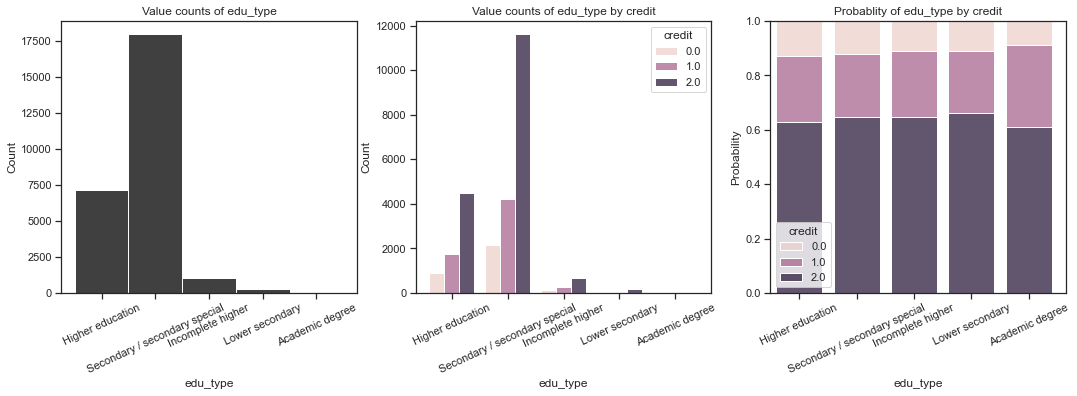

In [387]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.histplot(x = 'edu_type', stat = 'count', data = train, color = 'black')
plt.title('Value counts of edu_type')
plt.xticks(rotation = 25)

plt.subplot(1,3,2)
sns.histplot(x = 'edu_type', stat = 'count', data = train, hue = 'credit', 
             multiple= 'dodge', shrink=0.8)
plt.title('Value counts of edu_type by credit')
plt.xticks(rotation = 25)

plt.subplot(1,3,3)
sns.histplot(x = 'edu_type', stat = 'probability', data = train, hue = 'credit', 
             multiple= 'fill', shrink=0.8)
plt.title('Probablity of edu_type by credit')
plt.xticks(rotation = 25)
plt.show()

- 학력 수준차이에 의해서는 credit에 직접적인 영향을 끼치지 않는것으로 확인된다.


In [ ]:
train['adj_edu_type'] = train.edu_type 
train.loc[train.edu_type == 'Academic degree', 'adj_edu_type'] = 'Higher education'

- 그러나 Academic degree에 해당하는 범주의 관측치의 수가 너무 적어 Higher education에 포함시키는 것을 선택했다. => ```adj_edu_type```


#### family_type
- 카드 사용자의 가족 형성 유형에 대한 변수
- 특히 배우자와의 관계에 대한 변수
- 이 변수와 child_num의 조합으로 family_size가 결정되는것을 추정해볼 수 있었다. 이에 대해 검토해본다.

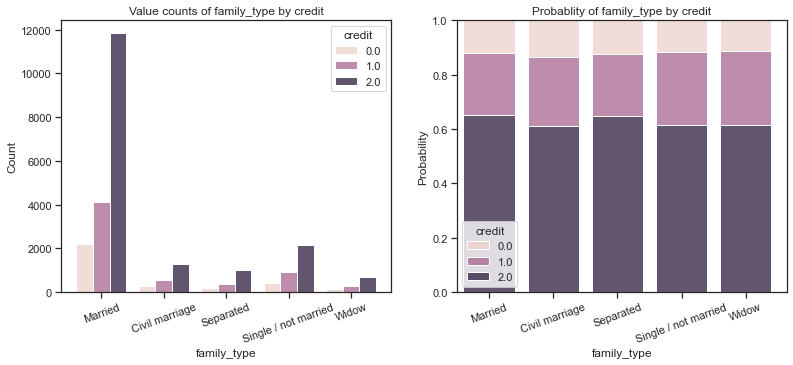

In [375]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.histplot(x = 'family_type', stat = 'count', data = train, hue = 'credit', 
             multiple= 'dodge', shrink=0.8)
plt.title('Value counts of family_type by credit')
plt.xticks(rotation = 20)

plt.subplot(1,2,2)
sns.histplot(x = 'family_type', stat = 'probability', data = train, hue = 'credit', 
             multiple= 'fill', shrink=0.8)
plt.title('Probablity of family_type by credit')
plt.xticks(rotation = 20)
plt.show()

In [161]:
for f_type in train.family_type.unique() : 
    print('*',f_type)
    print((train.family_size - train.child_num).loc[train.family_type == f_type].value_counts())
    print()
    

* Married
 2.0    18193
 0.0        2
-1.0        1
dtype: int64

* Civil marriage
2.0    2122
0.0       1
dtype: int64

* Separated
1.0    1539
dtype: int64

* Single / not married
1.0    3478
2.0      16
0.0       2
dtype: int64

* Widow
1.0    1103
dtype: int64



- family_size - child_num = (본인+배우자 유무)라는 공식이 성립하는 것으로 보인다.
- 하지만 성립하지 않은 데이터가 존재한다.
    - Married 에서 0에 2개의 관측치, -1에 1개의 관측치
    - Civil marriage에서 0에 1개의 관측치
    - Single / not married 에서 2에 16개 관측치, 0에 2개 관측치
    
- 성립하지 않은 데이터에 대해서 확인해보는 것이 필요하다.

In [192]:
train['exp_num'] = 0
train['exp_num'].loc[train.family_type == 'Married'] = 2
train['exp_num'].loc[train.family_type == 'Civil marriage'] = 2
train['exp_num'].loc[train.family_type == 'Separated'] = 1
train['exp_num'].loc[train.family_type == 'Single / not married'] = 1
train['exp_num'].loc[train.family_type == 'Widow'] = 1

train['odd_family_size'] = 0
train['odd_family_size'].loc[(train.family_size - train.child_num) != train.exp_num] = 1

In [205]:
train[['gender','_age', 'child_num', 'family_type', 'family_size', 'occyp_type', 'credit']][train['odd_family_size'] == 1].sort_values('family_type')

,gender,_age,child_num,family_type,family_size,occyp_type,credit
index,,,,,,,
18879,M,34.921287,1,Civil marriage,1.0,NaN,2.0
21096,M,44.966461,1,Married,1.0,Drivers,2.0
16791,F,33.237509,1,Married,1.0,Core staff,2.0
14900,M,40.454483,2,Married,1.0,Drivers,2.0
684,F,48.952772,0,Single / not married,2.0,Cooking staff,2.0
23249,M,48.145106,0,Single / not married,2.0,Drivers,2.0
22776,F,48.142368,0,Single / not married,2.0,Core staff,2.0
22262,F,51.950719,0,Single / not married,2.0,Core staff,2.0
21027,F,42.343600,1,Single / not married,3.0,Low-skill Laborers,2.0


- family_type == 'Married' & 'Civil marriage'
    - family_size == 1인 관측치가 발견된다. 이는 결혼도 했고 자녀도 있으나, 현재 거주지에 혼자 거주하는 것으로 추정한다.
- family_type == 'Single / not married'
    - family_size - child_num == 2, 결혼은 하지 않았으나 동거인이 있다고 추정한다. **(사실혼 관계로 추정 -> Married로 변경)** => ```adj_family_type```
    - family_size - child_num == 0, 자녀가 있지만 자녀와 따로 살고, 현재 거주지에 혼자 거주하는 것으로 추정한다.


- 추가적으로, 여기에 해당하는 데이터는 극히 적은 수이지만, 모든 관측치의 credit의 class가 2로 발견된다.

In [376]:
# 수정된 family_type 추가 : adj_family_type
train['adj_family_type'] = train['family_type']
train['adj_family_type'].loc[(train.family_type == 'Single / not married')&(train.family_size - train.child_num == 2)] = 'Married'

- 'Single / not married'는 자녀가 없는 것이 주류이다. 반대로 자녀가 있는 경우는 특이한 케이스라 판단하여 이를 구분할 수 있는 변수로 만들어 준다. => ```_single_parents```

In [389]:
# 논외로 family_type == 'Single / not married'에 자녀가 있는 경우도 변수를 추가해준다. => family_type 에서 다시 이야기
train['_single_parents'] = ((train.family_type == 'Single / not married')&(train.child_num != 0)).astype('int')
print('ratio of Single parents data : ',sum(train._single_parents)/len(train)*100,'%')

ratio of Single parents data :  1.9238764788146803 %


In [392]:
train.groupby('_single_parents').credit.value_counts(normalize = True)

_single_parents  credit
0                2.0       0.641784
                 1.0       0.235933
                 0.0       0.122283
1                2.0       0.618861
                 1.0       0.284872
                 0.0       0.096267
Name: credit, dtype: float64

- 단독으로 사는 사람들에 대한 정보 => ```_single_live```

In [394]:
train['_single_live'] = (train.family_size == 1).astype('int')
print('ratio of Single live data : ',sum(train._single_live)/len(train)*100,'%')

ratio of Single live data :  19.310579430774464 %


In [395]:
train.groupby('_single_live').credit.value_counts(normalize = True)

_single_live  credit
0             2.0       0.645587
              1.0       0.231825
              0.0       0.122588
1             2.0       0.623605
              1.0       0.257976
              0.0       0.118418
Name: credit, dtype: float64

#### house_type
- 카드 사용자의 거주 유형에 관한 변수


In [397]:
train.house_type.value_counts()

House / apartment      23653
With parents            1257
Municipal apartment      818
Rented apartment         429
Office apartment         190
Co-op apartment          110
Name: house_type, dtype: int64

- 대부분의 관측치가 'House / apartment' 범주에 속한다.

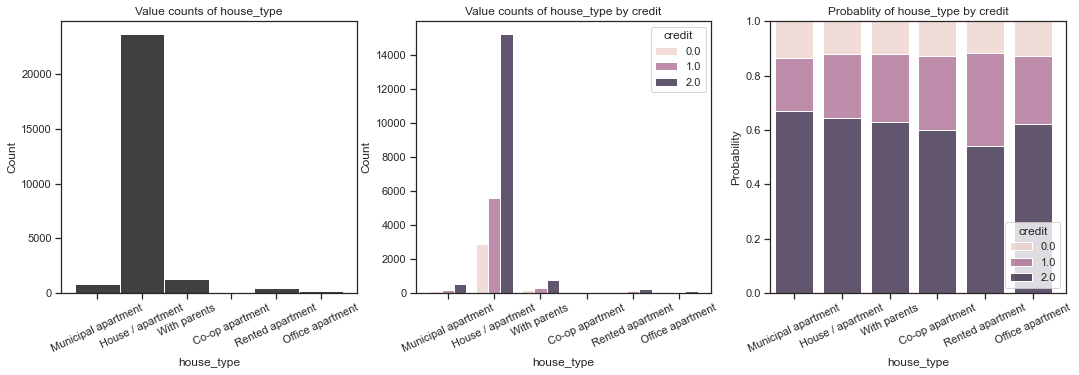

In [396]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.histplot(x = 'house_type', stat = 'count', data = train, color = 'black')
plt.title('Value counts of house_type')
plt.xticks(rotation = 25)

plt.subplot(1,3,2)
sns.histplot(x = 'house_type', stat = 'count', data = train, hue = 'credit', 
             multiple= 'dodge', shrink=0.8)
plt.title('Value counts of house_type by credit')
plt.xticks(rotation = 25)

plt.subplot(1,3,3)
sns.histplot(x = 'house_type', stat = 'probability', data = train, hue = 'credit', 
             multiple= 'fill', shrink=0.8)
plt.title('Probablity of house_type by credit')
plt.xticks(rotation = 25)
plt.show()

#### occyp_type
- 카드 사용자의 직업 유형에 대한 변수
- 가장 많은 범주를 가진 범주형 변수
- 결측치가 존재

In [410]:
print('number of missing value: ',sum(train.occyp_type.isna()))

number of missing value:  8171


In [420]:
# 전처리를 위한 새로운 데이터 생성  => adj_occyp_type
# 결측치가 어떤식으로 발생되었는지 다른 변수와의 관계를 확인하기 위해 'missing'이라는 value로 지정해줌
train['adj_occyp_type'] = train.occyp_type.fillna('missing')
train['_missing_occyp_type'] = train.occyp_type.isna().astype('int')

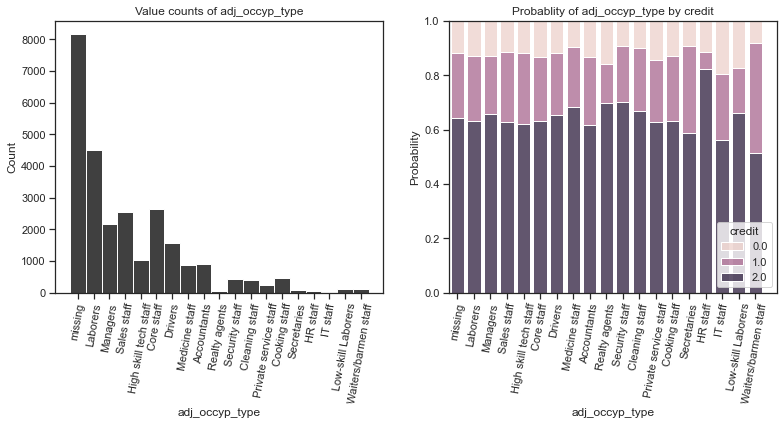

In [417]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.histplot(x = 'adj_occyp_type', stat = 'count', data = train, color = 'black')
plt.title('Value counts of adj_occyp_type')
plt.xticks(rotation = 80)

plt.subplot(1,3,2)
sns.histplot(x = 'adj_occyp_type', stat = 'probability', data = train, hue = 'credit', 
             multiple= 'fill', shrink=0.8)
plt.title('Probablity of adj_occyp_type by credit')
plt.xticks(rotation = 80)
plt.show()

- 결측치가 생긴 이유를 두가지로 추정해보면 다음과 같다
    - 카드 사용자의 종사하고 있는 직업이 없는 경우
    - 카드 사용자가 직업 기입을 누락시킨 경우
    
- 위의 경우에 대해서 파악해본다.

In [421]:
pd.crosstab(train.DAYS_EMPLOYED_missing, train._missing_occyp_type)

_missing_occyp_type,0,1
DAYS_EMPLOYED_missing,,
0,18286,3733
1,0,4438


In [422]:
pd.crosstab(train.income_type, train._missing_occyp_type)

_missing_occyp_type,0,1
income_type,,
Commercial associate,5176,1026
Pensioner,9,4440
State servant,1762,392
Student,6,1
Working,11333,2312


- DAYS_EMPLOYED == 365243인 모든 값들이 occyp_type에서 결측치로 확인
- income_type == 'Pensioner' (소득유형: 연금수령자)인 대부분의 관측치(4449개 중 4440개)가 occyp_type에서 결측치로 확인


- DAYS_EMPLOYED 측면으로는 카드 사용자가 직업이 없는 경우에 (4438건) occyp_type에서 결측이 일어난다고 본다. => 실제로 직업이 없는경우
- income_type 측면도 마찬가지로 연금수령자의 경우 직업이 없는 경우가 대부분이다.


- DAYS_EMPLOYED == 365243 인 결측치에 대해서 'inoccyp'(직업없음)으로 변경해준다.
- DAYS_EMPLOYED != 365243 인 결측치에 대해서는 'non_enter'(미기입)으로 변경해준다.

In [423]:
train.loc[(train.DAYS_EMPLOYED == 365243)&(train.occyp_type.isna()), 'adj_occyp_type'] = 'inoccyp'
train.loc[(train.DAYS_EMPLOYED != 365243)&(train.occyp_type.isna()), 'adj_occyp_type'] = 'non_enter'

### 중복데이터에 관한 이슈
- 데이터를 살펴보다보면 서로 다른 관측치에서 같은 사람으로 보이는 정보가 다수 발견된다. 이를 통해 이는 단순이 각 개인별 정보가 아닌 발급된 카드 중심의 데이터로 사용자의 중복은 있을 수도 있다는 것을 판단하였다. 이에 관한 변수를 지정해주는 작업의 필요성을 통해 다음과 같은 변수를 추가해준다.

#### 개인식별 변수 생성: ID
- 본 데이터의 카드 사용자들은 중복으로 보이는 데이터가 존재하는 것을 확인하였다. 이를 식별하는 데이터를 만들어준다.

In [434]:
train['ID'] = \
train['gender'].astype('str') + \
train['car'].astype('str') + \
train['reality'].astype('str') + '_' + \
train['income_total'].astype('str') + '_' + \
train['income_type'].astype('str') + '_' + \
train['DAYS_BIRTH'].astype('str') + '_' + \
train['DAYS_EMPLOYED'].astype('str') + '_' + \
train['occyp_type'].astype('str') 

In [453]:
train.ID.nunique()
print('number of ID   :   {} \nsize of train  :  {}'.format(train.ID.nunique(), len(train)))

number of ID   :   8735 
size of train  :  26457


- 이를통해 확인 가능한 사실은 train data는 8735명의 26457개의 카드 사용자의 정보이다.

#### 개인별 소지 카드 수: _card_num
- 개인 식별 정보 변수(ID)를 통해서 데이터에서 각 개인을 식별할 수 있었으니 각 개인이 사용중인 카드의 개수 또한 알 수 있다.
- 이에 대한 정보로 card_num이라는 데이터를 생성해준다.

In [456]:
train['_card_num'] = train.groupby('ID').ID.transform(len)

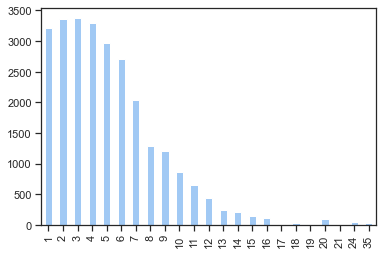

In [462]:
train['_card_num'].value_counts().sort_index().plot(kind = 'bar')
plt.show()

- 여러개의 카드를 사용하는 사람이 굉장히 많은 것으로 나타난다.

## Feature engineering
### 이상치 제거

In [465]:
# child_num >= 7 인 데이터 제거
train.drop((train[train['child_num'] >= 7]).index, axis = 0, inplace = True)

### 필요없는 Feature 제거

In [466]:
# FLAG_MOBIL는 모든 관측치가 1이기 때문에 제거해준다.
train.drop('FLAG_MOBIL', axis = 1, inplace = True)

### 파생변수 추가

#### 다음과 같은 변수를 추가적으로 생각 해 볼 수 있다.
- 배우자가 있는 경우, **배우자의 소득**을 고려. (X)
    - 배우자가 얼마나 버는지 알 수 없기때문에 보다 정확한 추정이 어려워 구하기 어렵다고 판단.
    
    
- 카드 소유자의 소득이 생활에 얼마나 영향을 주는지 고려.
    - 가족 구성원 수가 많을 수록 사용하는 **필수 생활비용**이 많이 필요할 것이다. 
    - 자동차를 소유하고 있는 경우, **자동차 유지비용**을 고려.  
    - (총 소득) - (총 비용) 을 통해 카드 소유자의 소득 대비 생활 여유도를 판단한다.
    
    
- 카드 소유자가 가진 카드들에 할당할 수 있는 금액을 고려.
    - 카드 소유자가 가진 카드가 2개 이상일 경우, 각 카드에 할당 가능한 금액은 항상 카드 소유자의 총 소득보다 작거나 같다. 
    - 카드에 각각 지불할 수 있는 금액에 따라 연체 기회가 달라질것이다.
    
    
- 

- 카드 데이터에서 모든 각 개인의 정보만 사용해야하므로, 개인에서 중복이 없는 데이터에서 구한다.


In [502]:
# 오직 개인 정보만 가지고 있는 데이터
personal_info = train.drop(['credit', 'begin_month'], axis = 1).drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)

##### 카드 소유자의 소득이 생활에 얼마나 영향을 주는지 고려.
- 필수 생활 비용은 가족 구성원 수, 카드 소유자의 나이에 대한 변수가 적용될 것이다.
    - 자녀가 많을 수록 자녀 양육비로 비용이 늘어날것이다.
    - 카드 소유자의 나이가 많아질수록 가족 각 구성원에 대한 비용이 줄어들것이다.
나이, 가족수, 소득

가족수 

- 35살 기준으로 크거나 작을 수록 양육비용이 줄어들것이다.


In [600]:
# 나이에 따른 양육비용 가중치
def child_fee_age_weights(x) : 
    from scipy.stats import norm
    sd = personal_info._age.std()
    return norm(35, scale = sd).pdf(x) / norm(35, scale = sd).pdf(35)

In [619]:
# 33~37세, 1인 자녀 기준 양육비
child_fee = (personal_info.income_total/personal_info.family_size)[(personal_info._age > 33) &\
                                                                   (personal_info._age < 37) &\
                                                                   (personal_info.child_num == 1)].mean()
print(child_fee)

68560.18641114983


In [620]:
# 자녀의 수, 변경
(np.log(personal_info.child_num + 1)/np.log(2)).value_counts() 

0.000000    6144
1.000000    1708
1.584963     769
2.000000     116
2.321928      16
2.584963       3
Name: child_num, dtype: int64

In [621]:
child_fees = (np.log(personal_info.child_num + 1)/np.log(2)) * (child_fee) * personal_info._age.apply(child_fee_age_weights)

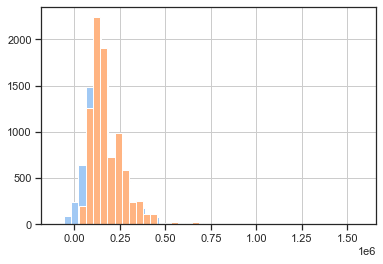

In [622]:
(personal_info.income_total - child_fees).hist(bins = 40)
personal_info.income_total.hist(bins = 40)

In [623]:
np.log(personal_info.income_total)

0       12.218495
1       12.419166
2       13.017003
3       12.218495
4       11.967181
          ...    
8751    12.323856
8752    12.100712
8753    12.586220
8754    12.049419
8755    11.302204
Name: income_total, Length: 8756, dtype: float64

#### 소득에 관한 변수
- 소득에 관한 변수는 <u>카드 사용자 본인 총 소득</u>과, <u>가계 총 소득(본인+배우자)</u>으로 나뉜다.(배우자가 없는 경우는 일치)
- 각각이 가진 의미가 다르기때문에, 상황에 맞는 변수 생성이 필요



- ```income_total```
    - 카드 사용자 개인의 총 소득으로 다음과 같은 정보를 고려할 수 있음.
    - 카드 사용자가 가진 카드에 각각 할당 될 수 있는 금액. 카드가 아무리 많아도 주로 사용하는 카드는 정해져 있으므로 카드 개수는 많아져도 그 영향은 미비할것이라는 가정하에 다음과 같은 공식을 사용한다.   
        => (개인 총 소득) / log(사용자의 카드 수)
- ```_income_family```
    - 카드 사용자의 가계 총 소득으로 다음과 같은 정보를 고려할 수 있음.
    - 가족 구성원의 각자에게 할당된 금액.  
        =>  (가계 총 소득) / (가족 수)
    - 가족간에 생계를 유지해나갈 정도의 최소 금액을 제외한 해당 카드 사용자의 여유자금.  
        => (가계 총 소득) - (가족 수) * (인 당 최소 생계 유지비용)
    - 



- 인 당 최소 생계 유지비용은 다음과 같은 공식으로 가정한다.
    - '(가계 총 소득) / (가족 수)' 중위값의 85%
- 자동차를 보유하고 있는 개인은 본인 자동차 유지비용에 대한 가중치도 고려한다.
    - 자차보유한 개인들 중, 개인 소득의 중위값의 10%를 

In [ ]:
train['_income_per_person'] =  train.income_total / train.family_size

train['_income_per_person_adj'] = ( train.income_total - train.income_total.min()*0.8 )/ train.family_size

train['_income_per_child'] = train.income_total / train.child_num

train['_income_per_child_adj'] = ( train.income_total - train.income_total.min()*0.8 )/ train.child_num

- 개인 총 소득을 소유하고 있는 카드의 수로 나눈 변수
- 카드 당 할애될 수 있는 금액의 평균을 확인 하기 위한 변수
- 카드가 아무리 많아도 사용하는 카드의 개수는 정해져 있으므로 카드 개수에 log를 취해줘서 가중치를 준다.

In [ ]:
train['_income_per_card'] = train.income_total / (1+np.log(train._card_num))

train['_income_per_card_adj'] = ( train.income_total - train.income_total.min()*0.8 ) / (1+np.log(train._card_num))

In [ ]:
train['_income_per_age'] = ( train.income_total - train.income_total.min()*0.8 ) / train._card_num

In [470]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26451 entries, 0 to 26456
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       26451 non-null  int64  
 1   car                          26451 non-null  int64  
 2   reality                      26451 non-null  int64  
 3   child_num                    26451 non-null  int64  
 4   income_total                 26451 non-null  float64
 5   income_type                  26451 non-null  object 
 6   edu_type                     26451 non-null  object 
 7   family_type                  26451 non-null  object 
 8   house_type                   26451 non-null  object 
 9   DAYS_BIRTH                   26451 non-null  int64  
 10  DAYS_EMPLOYED                26451 non-null  int64  
 11  work_phone                   26451 non-null  int64  
 12  phone                        26451 non-null  int64  
 13  email           

In [474]:
train.adj_family_typ

index
0                     Married
1              Civil marriage
2                     Married
3                     Married
4                     Married
                 ...         
26452                 Married
26453               Separated
26454          Civil marriage
26455    Single / not married
26456          Civil marriage
Name: adj_family_type, Length: 26451, dtype: object